In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from correlation_metrics import register_act, plot_metrics

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def train_loop(experiment):
    accs = [] # test loss
    ent = [] # entropy
    class_acc = []
    t_acc = []
    grads = []

    np.random.seed(np.random.randint(0,100))
    train_labels = np.reshape(np.random.permutation(np.arange(1,11)), (5,2))

    epochs = 1
    indices = []


    for label in train_labels:
        print("training on class {}".format(label))

        indices = np.hstack([0,np.delete(train_labels,np.where(train_labels==label)[0],axis=0).flatten()])

        for epoch in range(epochs):
            print("training: epoch {}".format(epoch+1))
            experiment.train(epoch, label, indices)   

    #         print(torch.max(torch.abs(experiment.model.output.weight.grad[indices,:])))

            mt = experiment.test()
            t_acc.append(mt["mean_accuracy"])

    #         grads.append(experiment.model.output.weight.grad.cpu().numpy())

        ct = [experiment.test_class(k)["mean_accuracy"] for k in range(1,11)]
        class_acc.append(ct)

        t = experiment.test()
        print("Mean accuracy: {}".format(t["mean_accuracy"]))
        accs.append(t["mean_accuracy"])
        ent.append(np.round(t["entropy"]))

    offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = register_act(experiment)
        
    return offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods

In [85]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"

odcorrs = []
dcorrs = []
oddotproducts = []
ddotproducts = []
for exp in ["denseCNN2", "sparseCNN2"]:
    config_init = parse_config(config_file)
    config = config_init[exp]
    config["name"] = exp
    config["seed"] = np.random.randint(0,200)
    config["data_dir"] = data_dir
    config["batch_size"] = 32
    config["num_classes"] = 11
    
    if exp=="sparseCNN2" or exp=="SuperSparseCNN2":
        a = 1
        config["cnn_weight_sparsity"] = (a*0.25, a*0.2)
        config["cnn_percent_on"] = (a*0.095, a*0.125)

    config["freeze_params"] = "output"

    exp_count = 0

#     for boost_off in range(2):
#             exp_count += 1

#             if boost_off == 1:
#                 config["boost_strength"] = 0.0
#                 config["boost_strength_factor"] = 0.0

    experiment = ContinuousSpeechExperiment(config=config)
    for epoch in range(2):
        experiment.train_entire_dataset(epoch)
        t = experiment.test()
        print("Mean accuracy: {}".format(t["mean_accuracy"]))
    
#     offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = train_loop(experiment)

    offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = register_act(experiment)
    
    odcorrs.append(offdiag_corrs)
    dcorrs.append(diag_corrs)
    oddotproducts.append(offdiag_dotprods)
    ddotproducts.append(diag_dotprods)

model on GPU
Creating optimizer with learning rate= 0.01
Mean accuracy: 51.2539184952978
Mean accuracy: 71.6692789968652
model on GPU
Creating optimizer with learning rate= 0.01
Mean accuracy: 85.61912225705329
Mean accuracy: 89.69435736677116


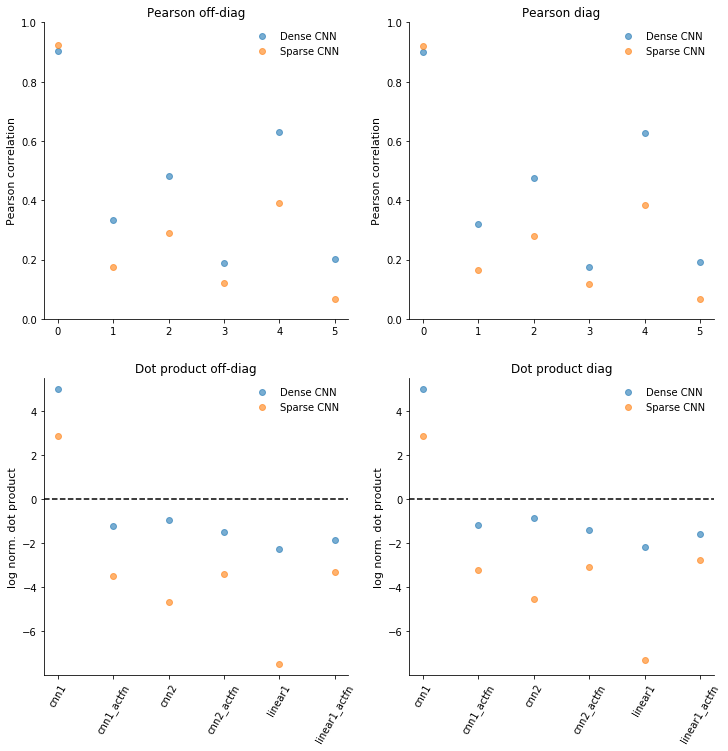

In [86]:
plot_metrics(metrics)
plt.savefig("../plots/corr_quantification_on_offdiags_whole_dataset.pdf")

In [ ]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"
exp = "SuperSparseCNN2"
config_init = parse_config(config_file)
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["data_dir"] = data_dir
config["batch_size"] = 32
config["num_classes"] = 11

config["freeze_params"] = "output"

exp_count = 0
corrs = []
dotproducts = []
for boost_off in range(2):
    for ind in [1,2,4]:
        exp_count += 1
        
        a = 1/ind
        config["cnn_out_channels"] = (int(64/a), int(64/a))
        config["cnn_weight_sparsity"] = (a*0.25, a*0.2)
        config["cnn_percent_on"] = (a*0.047, a*0.125)

        if boost_off == 1:
            config["boost_strength"] = 0.0
            config["boost_strength_factor"] = 0.0

        experiment = ContinuousSpeechExperiment(config=config)
    
        cs, ds = train_loop(experiment)
    
        corrs.append(cs)
        dotproducts.append(ds)

In [13]:
np.save("../plots/correlations_models_perclass.npy", corrs)
np.save("../plots/dotprods_models_perclass.npy", dotproducts)

In [3]:
ccs = np.load("../plots/correlations_models_perclass.npy", allow_pickle=True)
dps = np.load("../plots/dotprods_models_perclass.npy", allow_pickle=True)

In [22]:
order_ = [0,2,4,6,9,11]

fdots = [[dps[0][k] for k in order_],
          [dps[2][k] for k in order_],
         ]

module_keys = ["cnn1", "cnn1_actfn","cnn2", "cnn2_actfn","linear1", "linear1_actfn"]

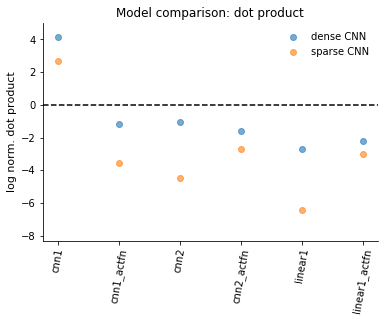

In [23]:
fig, ax = plt.subplots()

[plt.plot(np.log(k), 'o', alpha=0.6) for k in fdots]

plt.xticks(range(6), module_keys, rotation=80)
plt.ylim((-8.3, 5))
plt.title("Model comparison: dot product")
plt.axhline([0], color="k", linestyle="--")
plt.ylabel("log norm. dot product", fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(["dense CNN","sparse CNN"], frameon=False)
plt.savefig("../plots/permodel_dotprod_perclass_2_v2.pdf", bbox_inches="tight")

In [22]:
tmp = np.vstack(dotproducts)
plt.plot(np.log(tmp[:3,:]).T,'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylabel("log(normalized dot product)", fontsize=11)
# plt.ylim((-7, 5))
plt.axhline(0, color='k', linestyle='--')
plt.legend(('64', '128', '256'), loc="lower right", title="layer size")
plt.title("boosting on")
# plt.savefig("../plots/size_comp_dotprod.svg")

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 15 and the array at index 1 has size 14

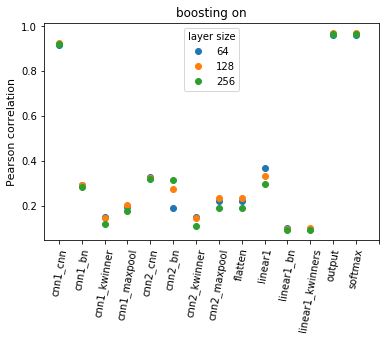

In [157]:
scorrs = np.vstack(corrs)
plt.plot((scorrs[:3,:]).T,'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylabel("Pearson correlation", fontsize=11)
# plt.ylim((-7, 5))
# plt.axhline(0, color='k', linestyle='--')
plt.legend(('64', '128', '256'), loc="upper center", title="layer size")
plt.title("boosting on")
plt.savefig("../plots/size_comp_pearson.svg")

/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


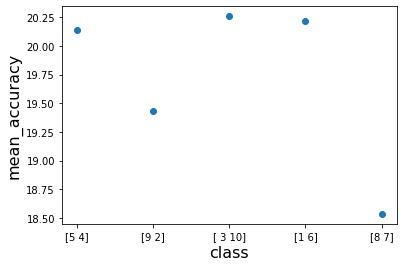

In [42]:
plt.plot(accs,'o')
plt.xlabel('class', fontsize=16)
plt.ylabel('mean_accuracy', fontsize=16)
plt.xticks(range(5),labels=train_labels);
# plt.ylim((5.,25.));

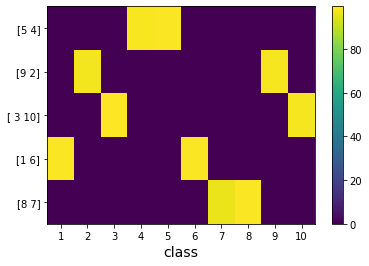

In [43]:
plt.imshow(class_acc, aspect="auto")
plt.yticks(range(5),labels=train_labels)
plt.xticks(range(10), range(1,11));
plt.xlabel("class", fontsize=14)
plt.colorbar();

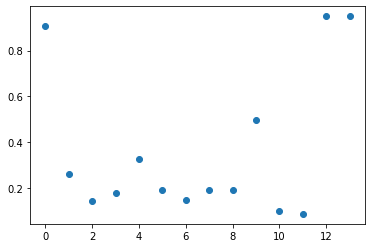

In [99]:
plt.plot(c,'o')

In [10]:
all_keys

dict_keys(['cnn1_cnn', 'cnn1_bn', 'cnn1_kwinner', 'cnn1_maxpool', 'cnn2_cnn', 'cnn2_bn', 'cnn2_kwinner', 'cnn2_maxpool', 'flatten', 'linear1', 'linear1_bn', 'linear1_kwinners', 'output', 'softmax'])

In [9]:
act = {}
def get_act(name):
    def hook(model, input_, output):
        act[name] = output.detach().cpu().numpy()
    return hook
 
cnt = 0
layer_list = list(experiment.model.named_children())
k = [x[0] for x in layer_list]

for module in experiment.model:
    module.register_forward_hook(get_act(k[cnt]))
    cnt += 1

outputs = []
for k in range(1,11):
    act = {}
    loader = experiment.test_loader[k]
    x,_ = next(iter(loader))
    experiment.model(x.cuda())
    outputs.append(act)

all_keys = outputs[0].keys()

In [47]:
corr_mats = []
dot_mats = []

for key in all_keys:
    mod_output = [np.vstack([outputs[n][key][k,:].flatten() for k in range(experiment.batch_size)])
                  for n in range(len(outputs))]

    corr_mat = np.zeros((10,10))
    iu = np.triu_indices(experiment.batch_size,1)
    dot_mat = np.zeros((10,10))
    
    m_len = mod_output[0].shape[1]

    for i in range(10):
        for j in range(10):
            corr_mat[i,j] = np.corrcoef(mod_output[i], mod_output[j])[iu].mean()
            
            dot_mat[i,j] = np.mean([np.dot(mod_output[i][x,:],mod_output[j][y,:])/m_len
                                    for x in range(experiment.batch_size) for y in range(experiment.batch_size)])
            
    corr_mats.append(corr_mat)
    dot_mats.append(dot_mat)
    


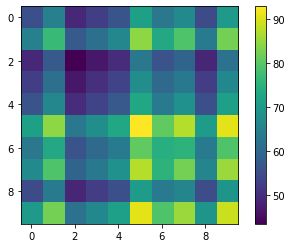

In [48]:
plt.imshow(dot_mat)
plt.colorbar()

In [72]:
np.triu(dot_mat,0)
ids = np.triu_indices(10,0)
np.mean(np.triu(dot_mat,0)[ids])

66.33581834878804

In [49]:
ccs = [np.mean(np.triu(k,1)) for k in corr_mats]

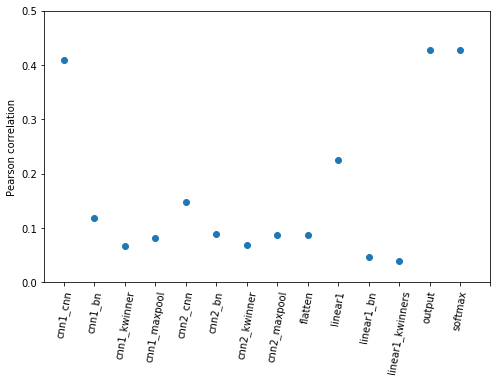

In [50]:
plt.figure(figsize=(8,5))
plt.plot(ccs, 'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylim((0., 0.5))
plt.ylabel("Pearson correlation")
plt.savefig("../plots/{}_{}_pearson_2cpe_2pctgrad.jpg".format(config["cnn_out_channels"][0], config["cnn_out_channels"][1]))

In [51]:
ds = [np.mean(np.triu(k,0)) for k in dot_mats]

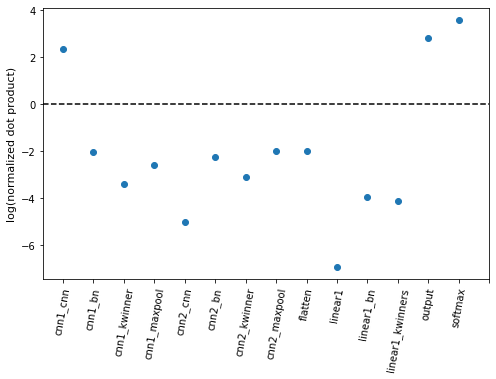

In [52]:
plt.figure(figsize=(8,5))
plt.plot(np.log(ds), 'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylabel("log(normalized dot product)", fontsize=11)
# plt.ylim((-7, 5))
plt.axhline(0, color='k', linestyle='--')
plt.savefig("../plots/{}_{}_dotp_2cpe_2pctgrad.jpg".format(config["cnn_out_channels"][0], config["cnn_out_channels"][1]))

In [39]:
torch.index_select?

In [86]:
experiment.model

LeSparseNet(
  (cnn1_cnn): SparseWeights2d(
    weight_sparsity=0.5
    (module): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn1_kwinner): KWinners2d(channels=64, local=False, n=50176, percent_on=0.095, boost_strength=0.8857348561286926, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_cnn): SparseWeights2d(
    weight_sparsity=0.2
    (module): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn2_kwinner): KWinners2d(channels=64, local=False, n=6400, percent_on=0.125, boost_strength=0.8857348561286926, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [158]:
1

1

In [22]:
os.mkdir("../plots")

In [53]:
experiment.freeze_params

'output'